In [21]:
import pandas as pd
import numpy as np
import describe as tatl
import wrangle as get
import model as mod
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# feature selection imports
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

# import scaling methods
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer
# import modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, mutual_info_score
from sklearn.metrics import mean_squared_error, r2_score

from mitosheet import *
import plotly.express as px
# import to remove warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# I'll need to drop country, year, and year_int

In [3]:
df, train, validate, test = get.wrangle_df()

Dataframe Input received: Splitting Data .5/.3/.2.
Train: (150, 23), Validate (90, 23), and Test (60, 23) are ready.    
 Proceed with EDA.


In [4]:
train.columns

Index(['country', 'year', 'cgdpe', 'ctfp', 'cwtfp', 'rtfpna', 'rwtfpna',
       'labsh', 'irr', 'delta', 'pl_con', 'pl_da', 'pl_gdpo', 'csh_c', 'csh_i',
       'csh_g', 'csh_r', 'pl_c', 'pl_g', 'pl_x', 'pl_k', 'both_sexes',
       'year_int'],
      dtype='object')

In [11]:
def wrangle_df2(target):
    ''' 
    '''
    df, train, validate, test = get.wrangle_df()
    # first drop the columns I won't be using and that are unscalable. 
    train = train.drop(columns=(['country', 'year', 'year_int']))
    validate = validate.drop(columns=(['country', 'year', 'year_int']))
    test = test.drop(columns=(['country', 'year', 'year_int']))
    
    # split train into X (dataframe, drop target) & y (series, keep target only)
    X_train = train.drop(columns=[target])
    y_train = train[target]
    
    # split validate into X (dataframe, drop target) & y (series, keep target only)
    X_validate = validate.drop(columns=[target])
    y_validate = validate[target]
    
    # split test into X (dataframe, drop target) & y (series, keep target only)
    X_test = test.drop(columns=[target])
    y_test = test[target]
    
    # Change series into data frame for y 
    y_train = pd.DataFrame(y_train)
    y_validate = pd.DataFrame(y_validate)
    y_test = pd.DataFrame(y_test)
    
    return train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test

In [2]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = get.wrangle_df2('both_sexes')

In [5]:
#train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle_df2('both_sexes')

In [3]:
X_train.shape, X_validate.shape, X_test.shape

((150, 19), (90, 19), (60, 19))

In [8]:
y_train.shape, y_validate.shape, y_test.shape

((150, 1), (90, 1), (60, 1))

In [6]:
# checking again to make sure the updated wrangle function works
X_train.shape, X_validate.shape, X_test.shape

((150, 19), (90, 19), (60, 19))

In [7]:
y_train.shape, y_validate.shape, y_test.shape
# good to go. 

((150, 1), (90, 1), (60, 1))

In [8]:
X_train.columns

Index(['cgdpe', 'ctfp', 'cwtfp', 'rtfpna', 'rwtfpna', 'labsh', 'irr', 'delta',
       'pl_con', 'pl_da', 'pl_gdpo', 'csh_c', 'csh_i', 'csh_g', 'csh_r',
       'pl_c', 'pl_g', 'pl_x', 'pl_k'],
      dtype='object')

In [4]:
def scale_data(X_train, X_validate, X_test, return_scaler=False):
    '''
    Scales the 3 data splits.
    takes in the train, validate, and test data splits and returns their scaled counterparts.
    If return_scaler is true, the scaler object will be returned as well.
    Target is not scaled.
    columns_to_scale was originally used to check whether los_angeles and orange would cause trouble
    '''
    columns_to_scale = X_train.columns
    
    X_train_scaled = X_train.copy()
    X_validate_scaled = X_validate.copy()
    X_test_scaled = X_test.copy()
    
    scaler = MinMaxScaler()
    scaler.fit(X_train_scaled[columns_to_scale])
    
    X_train_scaled[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
    X_validate_scaled[columns_to_scale] = scaler.transform(X_validate[columns_to_scale])
    X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
    
    if return_scaler:
        return scaler, X_train_scaled, X_validate_scaled, X_test_scaled
    else:
        return X_train_scaled, X_validate_scaled, X_test_scaled

In [5]:
X_train_scaled, X_validate_scaled, X_test_scaled = scale_data(X_train, X_validate, X_test)

In [16]:
baseline = pd.DataFrame({
        'median' : [y_train.median()] * y_train.size,
        'mean' : [y_train.mean()] * y_train.size
    })

median_rmse = mod._RMSE(y_train, baseline["median"])
mean_rmse = mod._RMSE(y_train, baseline["mean"])

print(median_rmse)
print(mean_rmse)
print('The Root Mean Squared Error of Mean is lower, indicating it will be the better baseline')

9.556160316779955
9.076787512967103
The Root Mean Squared Error of Mean is lower, indicating it will be the better baseline


In [ ]:
# keep results in a dictionary.

In [14]:
baseline_val = pd.Series([y_train.mean()] * y_validate.size)

results = {
    'baseline' : {
        'RMSE' : mean_squared_error(y_train, baseline['mean'], squared = False),
        'R^2' : r2_score(y_train, baseline['mean']),
        'RMSE_val' : mean_squared_error(y_validate, baseline_val, squared = False),
        'R^2_val' : r2_score(y_validate, baseline_val)
    }
}
results

{'baseline': {'RMSE': 9.076787512967103,
  'R^2': 0.0,
  'RMSE_val': 7.226867022642867,
  'R^2_val': -0.15322056907666481}}

In [ ]:
#def create_baseline(y_train, y_validate):
#    # 1. Predict mean tax value 
#    sui_pred_mean = y_train.both_sexes.mean()
#    y_train['sui_pred_mean'] = tv_pred_mean
#    y_validate['tv_pred_mean'] = tv_pred_mean
#    
#    # 2. Predict median tax value 
#    tv_pred_median = y_train.tax_value.median()
#    y_train['tv_pred_median'] = tv_pred_median
#    y_validate['tv_pred_median'] = tv_pred_median
#    
#    # 3. RMSE of tv_pred_mean
#    rmse_train = mean_squared_error(y_train.tax_value, y_train.tv_pred_mean) ** 0.5
#    rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tv_pred_mean) ** 0.5
#    
#    print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
#          "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))
#    
#    # 4. RMSE of tv_pred_median
#    rmse_train1 = mean_squared_error(y_train.tax_value, y_train.tv_pred_median) ** .5
#    rmse_validate1 = mean_squared_error(y_validate.tax_value, y_validate.tv_pred_median) ** .5
#    print('-----------')
#    print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train1, 2), 
#          "\nValidate/Out-of-Sample: ", round(rmse_validate1, 2))
#    
#    return 
#    metric_df = pd.DataFrame(data=[{
#        'model': 'mean_baseline',
#        'rmse_outofsample': rmse_validate,
#        'r^2_outofsample': explained_variance_score(y_validate.tax_value, y_validate.tv_pred_mean)}])

In [11]:
mod.establish_baseline(y_train.both_sexes)

0      18.288667
1      18.288667
2      18.288667
3      18.288667
4      18.288667
         ...    
145    18.288667
146    18.288667
147    18.288667
148    18.288667
149    18.288667
Name: mean, Length: 150, dtype: float64

In [13]:
# checked the scaled dataframes, all good

In [18]:
# Select K Best
from sklearn.feature_selection import SelectKBest, f_regression

# parameters: f_regression stats test, give me 8 features
f_selector = SelectKBest(f_regression, k=8)

# find the top 8 X's correlated with y
f_selector.fit(X_train_scaled, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()


In [19]:
f_feature

['ctfp', 'cwtfp', 'rtfpna', 'rwtfpna', 'labsh', 'csh_i', 'csh_r', 'pl_g']

In [28]:
def select_rfe(X_train_scaled, y_train, k, return_rankings=False, model=LinearRegression()):
    # Use the passed model, LinearRegression by default
    rfe = RFE(model, n_features_to_select=k)
     # fit the data using RFE
    rfe.fit(X_train_scaled, y_train)
    # transforming data using RFE
    X_rfe = rfe.fit_transform(X_train_scaled, y_train)
    # get mask of columns selected as list
    feature_mask = X_train_scaled.columns[rfe.support_].tolist()
    if return_rankings:
        rankings = pd.Series(dict(zip(X_train_scaled.columns, rfe.ranking_)))
        return feature_mask, rankings, X_rfe
    else:
        return feature_mask, X_rfe

In [29]:
feature_mask, rankings, X_rfe = select_rfe(X_train_scaled, y_train, 8, return_rankings=True)

In [30]:
X_rfe

array([[0.7438896 , 0.70860664, 0.65877004, ..., 0.42208548, 0.41337377,
        0.52687528],
       [0.07918327, 0.08689201, 0.13346079, ..., 0.0730772 , 0.0683474 ,
        0.04527937],
       [0.25471355, 0.28408365, 0.53767475, ..., 0.13115007, 0.12416487,
        0.10151586],
       ...,
       [0.52877141, 0.47021142, 0.87533836, ..., 0.49126416, 0.47152805,
        0.33258922],
       [0.14196642, 0.16021364, 0.46939451, ..., 0.14416663, 0.12352098,
        0.13628374],
       [0.78982673, 0.86808235, 0.73583539, ..., 0.70673775, 0.66819018,
        0.90009052]])

In [33]:
feature_mask

['ctfp', 'cwtfp', 'rwtfpna', 'labsh', 'pl_con', 'pl_gdpo', 'pl_c', 'pl_g']

Recursive Feature Elimination is more accurate. 
RFE recursively removes attributes and then builds a model on those attributes that remain. The RFE method takes the machine learning algorithm to be used and the number of required features as input. It returns the ranking of all the variables, 1 being most important, along with its support: a list of boolean values, True indicating relevant features and False indicating irrelevant features.

array([[<AxesSubplot:title={'center':'both_sexes'}>]], dtype=object)

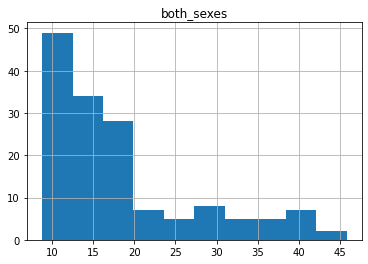

In [74]:
# It helps to know distributions of target before modeling
y_train.hist()

In [75]:
# Resembles a log normal, gamma, or poisson distribution. 

In [34]:
model = LinearRegression()
model.fit(X_train[feature_mask], y_train)

r2_score(y_train, model.predict(X_train[feature_mask]))

0.6768256041954956

In [35]:
mean_squared_error(y_train, model.predict(X_train[feature_mask]), squared = False)

5.160011167281029

In [36]:
results['linear_regression'] = {
    'RMSE' : mean_squared_error(y_train, model.predict(X_train[feature_mask]), squared = False),
    'R^2' : r2_score(y_train, model.predict(X_train[feature_mask])),
    'RMSE_val' : mean_squared_error(y_validate, model.predict(X_validate[feature_mask]), squared = False),
    'R^2_val' : r2_score(y_validate, model.predict(X_validate[feature_mask]))
}

In [37]:
results

{'baseline': {'RMSE': 9.076787512967103,
  'R^2': 0.0,
  'RMSE_val': 7.226867022642867,
  'R^2_val': -0.15322056907666481},
 'linear_regression': {'RMSE': 5.160011167281029,
  'R^2': 0.6768256041954956,
  'RMSE_val': 4.709374544061295,
  'R^2_val': 0.5102902884941921}}

In [64]:
# OLS
model = LinearRegression(normalize=True)
model.fit(X_train[feature_mask], y_train)

r2_score(y_train, model.predict(X_train[feature_mask]))

0.6768256041954956

In [65]:
mean_squared_error(y_train, model.predict(X_train[feature_mask]), squared = False)

5.16001116728103

In [66]:
results['linear_regression_OLS'] = {
    'RMSE' : mean_squared_error(y_train, model.predict(X_train[feature_mask]), squared = False),
    'R^2' : r2_score(y_train, model.predict(X_train[feature_mask])),
    'RMSE_val' : mean_squared_error(y_validate, model.predict(X_validate[feature_mask]), squared = False),
    'R^2_val' : r2_score(y_validate, model.predict(X_validate[feature_mask]))
}

In [68]:
# LASSO + LARS

model = LassoLars(alpha = 1.0)
model.fit(X_train[feature_mask], y_train)

r2_score(y_train, model.predict(X_train[feature_mask]))

0.0

In [69]:
mean_squared_error(y_train, model.predict(X_train[feature_mask]), squared = False)

9.076787512967103

In [70]:
results['LASSO+LARS'] = {
    'RMSE' : mean_squared_error(y_train, model.predict(X_train[feature_mask]), squared = False),
    'R^2' : r2_score(y_train, model.predict(X_train[feature_mask])),
    'RMSE_val' : mean_squared_error(y_validate, model.predict(X_validate[feature_mask]), squared = False),
    'R^2_val' : r2_score(y_validate, model.predict(X_validate[feature_mask]))
}

In [76]:
# Polynomial Regression
poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
poly.fit(X_train[feature_mask])

X_train_poly = pd.DataFrame(
    poly.transform(X_train[feature_mask]),
    columns = poly.get_feature_names(X_train[feature_mask].columns),
    index = X_train[feature_mask].index
)

model = LinearRegression()
model.fit(X_train_poly, y_train)

r2_score(y_train, model.predict(X_train_poly))

0.935812479644225

In [39]:
mean_squared_error(y_train, model.predict(X_train_poly), squared = False)

2.2996273654758213

In [40]:
# Before we make predictions on validate we need to prepare the X_validate set with the polynomial features.
poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
poly.fit(X_validate[feature_mask])

X_validate_poly = pd.DataFrame(
    poly.transform(X_validate[feature_mask]),
    columns = poly.get_feature_names(X_validate[feature_mask].columns),
    index = X_validate[feature_mask].index
)

In [41]:
results['polynomial_regression'] = {
    'RMSE' : mean_squared_error(y_train, model.predict(X_train_poly), squared = False),
    'R^2' : r2_score(y_train, model.predict(X_train_poly)),
    'RMSE_val' : mean_squared_error(y_validate, model.predict(X_validate_poly), squared = False),
    'R^2_val' : r2_score(y_validate, model.predict(X_validate_poly))
}

In [42]:
results

{'baseline': {'RMSE': 9.076787512967103,
  'R^2': 0.0,
  'RMSE_val': 7.226867022642867,
  'R^2_val': -0.15322056907666481},
 'linear_regression': {'RMSE': 5.160011167281029,
  'R^2': 0.6768256041954956,
  'RMSE_val': 4.709374544061295,
  'R^2_val': 0.5102902884941921},
 'polynomial_regression': {'RMSE': 2.2996273654758213,
  'R^2': 0.935812479644225,
  'RMSE_val': 9.803503394416884,
  'R^2_val': -1.1221440481190181}}

In [44]:
# Polynomial Regression with Interactions Only
poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = True)
poly.fit(X_train[feature_mask])

X_train_poly = pd.DataFrame(
    poly.transform(X_train[feature_mask]),
    columns = poly.get_feature_names(X_train[feature_mask].columns),
    index = X_train[feature_mask].index
)

model = LinearRegression()
model.fit(X_train_poly, y_train)

r2_score(y_train, model.predict(X_train_poly))

0.91417404288633

In [45]:
mean_squared_error(y_train, model.predict(X_train_poly), squared = False)

2.6591417968970905

In [46]:
# We have to prepare the validate set again

poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = True)
poly.fit(X_validate[feature_mask])

X_validate_poly = pd.DataFrame(
    poly.transform(X_validate[feature_mask]),
    columns = poly.get_feature_names(X_validate[feature_mask].columns),
    index = X_validate[feature_mask].index
)

In [47]:
results['polynomial_regression_interactions_only'] = {
    'RMSE' : mean_squared_error(y_train, model.predict(X_train_poly), squared = False),
    'R^2' : r2_score(y_train, model.predict(X_train_poly)),
    'RMSE_val' : mean_squared_error(y_validate, model.predict(X_validate_poly), squared = False),
    'R^2_val' : r2_score(y_validate, model.predict(X_validate_poly))
}

In [48]:
results

{'baseline': {'RMSE': 9.076787512967103,
  'R^2': 0.0,
  'RMSE_val': 7.226867022642867,
  'R^2_val': -0.15322056907666481},
 'linear_regression': {'RMSE': 5.160011167281029,
  'R^2': 0.6768256041954956,
  'RMSE_val': 4.709374544061295,
  'R^2_val': 0.5102902884941921},
 'polynomial_regression': {'RMSE': 2.2996273654758213,
  'R^2': 0.935812479644225,
  'RMSE_val': 9.803503394416884,
  'R^2_val': -1.1221440481190181},
 'polynomial_regression_interactions_only': {'RMSE': 2.6591417968970905,
  'R^2': 0.91417404288633,
  'RMSE_val': 9.525111913393829,
  'R^2_val': -1.0033296871086814}}

In [49]:
# Tweedie with Power of 1: Poisson distribution
# No collinearities from RFE is assumed, so alpha 0

model = TweedieRegressor(power = 1, alpha = 0)
model.fit(X_train[feature_mask], y_train)

r2_score(y_train, model.predict(X_train[feature_mask]))

0.7052060775560658

In [51]:
mean_squared_error(y_train, model.predict(X_train[feature_mask]), squared = False)

4.9282352598525305

In [52]:
results['tweedie_regressor_poisson'] = {
    'RMSE' : mean_squared_error(y_train, model.predict(X_train[feature_mask]), squared = False),
    'R^2' : r2_score(y_train, model.predict(X_train[feature_mask])),
    'RMSE_val' : mean_squared_error(y_validate, model.predict(X_validate[feature_mask]), squared = False),
    'R^2_val' : r2_score(y_validate, model.predict(X_validate[feature_mask]))
}

In [53]:
# Tweedie with Power of 1.5: Compound Poisson Gamma distribution
# No collinearities from RFE is assumed, so alpha 0

model = TweedieRegressor(power = 1.5, alpha = 0)
model.fit(X_train[feature_mask], y_train)

r2_score(y_train, model.predict(X_train[feature_mask]))

0.6958990391145662

In [54]:
mean_squared_error(y_train, model.predict(X_train[feature_mask]), squared = False)

5.0054262281590285

In [55]:
results['tweedie_regressor_compound_poisson_gamma'] = {
    'RMSE' : mean_squared_error(y_train, model.predict(X_train[feature_mask]), squared = False),
    'R^2' : r2_score(y_train, model.predict(X_train[feature_mask])),
    'RMSE_val' : mean_squared_error(y_validate, model.predict(X_validate[feature_mask]), squared = False),
    'R^2_val' : r2_score(y_validate, model.predict(X_validate[feature_mask]))
}

In [61]:
# it got even lower with power of 2. Moving on

In [71]:
pd.DataFrame(results).T

,RMSE,R^2,RMSE_val,R^2_val
baseline,9.076788,0.000000,7.226867,-0.153221
linear_regression,5.160011,0.676826,4.709375,0.510290
polynomial_regression,2.299627,0.935812,9.803503,-1.122144
polynomial_regression_interactions_only,2.659142,0.914174,9.525112,-1.003330
tweedie_regressor_poisson,4.928235,0.705206,4.679829,0.516416
tweedie_regressor_compound_poisson_gamma,5.005426,0.695899,4.701445,0.511938
linear_regression_OLS,5.160011,0.676826,4.709375,0.510290
LASSO+LARS,9.076788,0.000000,7.226867,-0.153221


R-Squared is the ratio of the Explained Sum of Squares (ESS) to the Total Sum of Squares (TSS). t is the explained variance by its very definition. 
Explained variance (also called explained variation) is used to measure the discrepancy between a model and actual data. In other words, it’s the part of the model’s total variance that is explained by factors that are actually present and isn’t due to error variance.

Higher percentages of explained variance indicates a stronger strength of association. It also means that you make better predictions (Rosenthal & Rosenthal, 2011).

In [83]:
# Fit best performing model on test 

# Polynomial Regression
poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
poly.fit(X_test[feature_mask])

X_test_poly = pd.DataFrame(
    poly.transform(X_test[feature_mask]),
    columns = poly.get_feature_names(X_train[feature_mask].columns),
    index = X_test[feature_mask].index
)

model = LinearRegression()
model.fit(X_test_poly, y_test)

r2_score(y_test, model.predict(X_test_poly))

results['TEST_polynomial_regression'] = {
    'RMSE' : mean_squared_error(y_test, model.predict(X_test_poly), squared = False),
    'R^2' : r2_score(y_test, model.predict(X_test_poly))
}

In [85]:
pd.DataFrame(results).T

,RMSE,R^2,RMSE_val,R^2_val
baseline,9.076788,0.000000,7.226867,-0.153221
linear_regression,5.160011,0.676826,4.709375,0.510290
polynomial_regression,2.299627,0.935812,9.803503,-1.122144
polynomial_regression_interactions_only,2.659142,0.914174,9.525112,-1.003330
tweedie_regressor_poisson,4.928235,0.705206,4.679829,0.516416
tweedie_regressor_compound_poisson_gamma,5.005426,0.695899,4.701445,0.511938
linear_regression_OLS,5.160011,0.676826,4.709375,0.510290
LASSO+LARS,9.076788,0.000000,7.226867,-0.153221
TEST_polynomial_regression,0.475029,0.990201,NaN,NaN
